In [1]:
import os # need to happen before loading numpy
os.environ["OMP_NUM_THREADS"] = "8" # export OMP_NUM_THREADS=8
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=8
os.environ["MKL_NUM_THREADS"] = "8" # export MKL_NUM_THREADS=8
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=8
os.environ["NUMEXPR_NUM_THREADS"] = "8" # export NUMEXPR_NUM_THREADS=8

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [209]:
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path    

if '../shap' not in sys.path:
    sys.path = ['../shap'] + sys.path
    import shap

import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import scipy as sp
import scipy.cluster
from collections import defaultdict
import matplotlib.pyplot as pl
import tqdm
from itertools import product


from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph
from flow import translator, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import GraphExplainer
from on_manifold import OnManifoldExplainer, IndExplainer

In [4]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True) # human readable feature values

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

print(X.shape)
X_display.head()

(32561, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


Age               35.0
Workclass          1.0
Education-Num      5.0
Marital Status     2.0
Occupation         5.0
Relationship       4.0
Race               2.0
Sex                1.0
Capital Gain       0.0
Capital Loss       0.0
Hours per week    40.0
Country           39.0
Name: 22, dtype: float64
output False


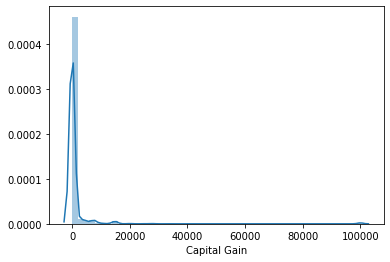

In [136]:
sample_idx = 22
print(X.iloc[sample_idx])
print('output', y[sample_idx])
sns.distplot(X['Capital Gain'])

In [5]:
# use validation set to choose # of trees
params = {
    "eta": 0.01,
    "max_depth": 4,
    'objective':'binary:logistic',
    "subsample": 0.9
}
model = xgboost.train(params, xgb_train, 3000, evals = [(xgb_test, "test")], verbose_eval=1000)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-error:0.15507
[1000]	test-error:0.12867
[2000]	test-error:0.12498
[2999]	test-error:0.12498


# Compare flat models

In [5]:
def build_graph(model, X, display_translator={}):
    '''
    build and return a graph (list of nodes), to be runnable in main
    model: xgboost model
    X: background distribution (n, d) dataframe object
    x: target samples to be explained (n2, d)
    names: the feature names of the d dimensional features
    display_translator: translate features values to readable format, see flow.py:translator
    '''
    # build the graph
    names = X.columns
    nodes = [Node(name) for name in names]
    nodes.append(Node('predicted income >50k', 
                      lambda *args: model.predict(xgboost.DMatrix(pd.DataFrame.from_dict(dict((name, args[i]) for i, name in enumerate(names))))),
                      nodes, is_target_node=True))
    
    graph = Graph(nodes, display_translator=display_translator)
    return graph
    
nsamples = 1000
graph = build_graph(model, X, translator(X.columns, X, X_display))
explainer = GraphExplainer(graph, X, nruns=100) 
cf = explainer.shap_values(X[:nsamples])

sampling: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


In [8]:
bg = shap.utils.sample(X, 100)
explainer = shap.Explainer(lambda x: model.predict(xgboost.DMatrix(x), validate_features=False), bg)
shap_values = explainer(X[:10]) #nsamples])

In [12]:
sample_ind = 3
print(X.iloc[sample_ind])
print('target:', model.predict(xgboost.DMatrix(X.iloc[sample_ind:sample_ind+1])))

Age               53.0
Workclass          4.0
Education-Num      7.0
Marital Status     2.0
Occupation         6.0
Relationship       4.0
Race               2.0
Sex                1.0
Capital Gain       0.0
Capital Loss       0.0
Hours per week    40.0
Country           39.0
Name: 3, dtype: float64
target: [0.07765882]


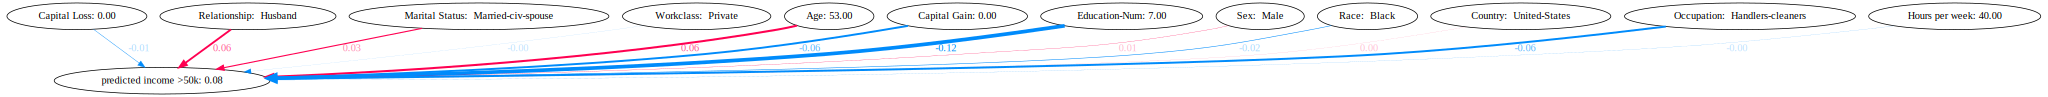

In [13]:
cf.draw(sample_ind)

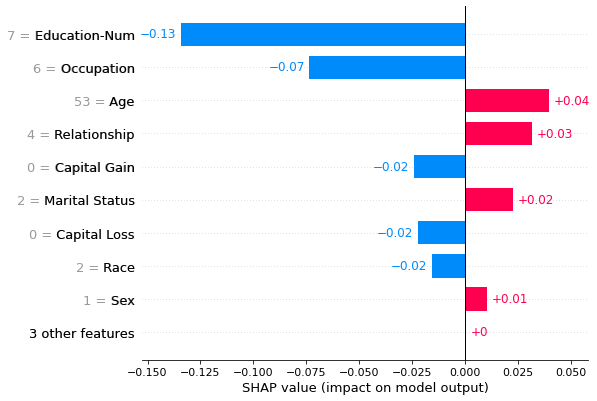

In [14]:
shap.plots.bar(shap_values[sample_ind])

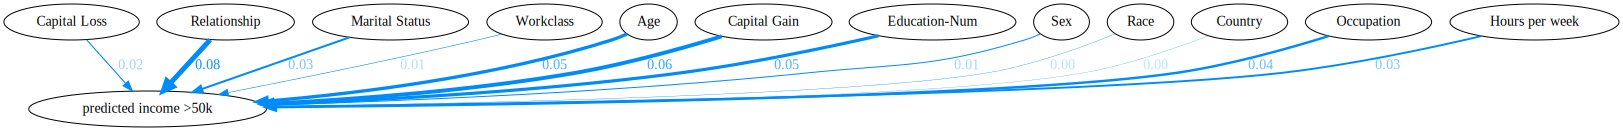

In [15]:
cf.draw(-1)

# Compare tree structures

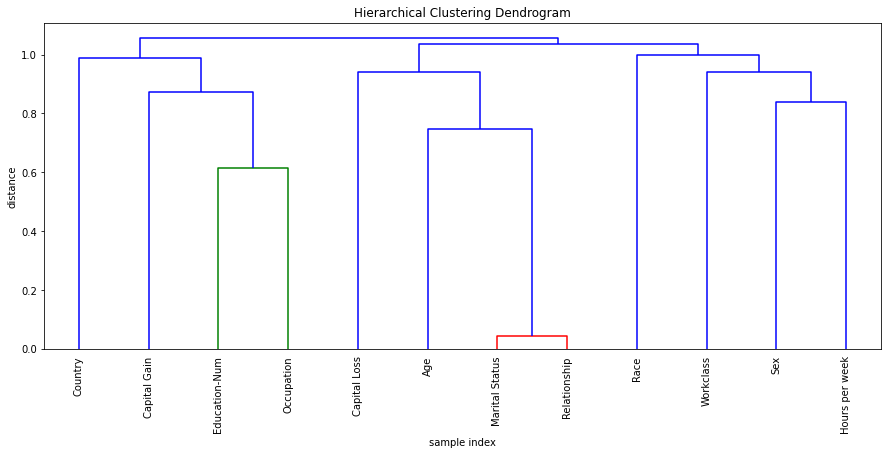

In [48]:
cluster_matrix = shap.utils.hclust(X, y)

# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

In [17]:
E = GraphExplainer(graph, X)
E.prepare_graph(X[:nsamples])
cf_h = CreditFlow(hcluster_graph(E.graph, list(X.columns), cluster_matrix), nruns=300)
cf_h.run()



sampling:   0%|          | 0/300 [00:00<?, ?it/s]

sampling:   0%|          | 1/300 [00:00<01:50,  2.70it/s]

sampling:   1%|          | 2/300 [00:00<01:50,  2.71it/s]

sampling:   1%|          | 3/300 [00:01<02:15,  2.19it/s]

sampling:   1%|▏         | 4/300 [00:02<03:02,  1.62it/s]

sampling:   2%|▏         | 5/300 [00:03<03:41,  1.33it/s]

sampling:   2%|▏         | 6/300 [00:04<04:09,  1.18it/s]

sampling:   2%|▏         | 7/300 [00:05<04:21,  1.12it/s]

sampling:   3%|▎         | 8/300 [00:06<04:32,  1.07it/s]

sampling:   3%|▎         | 9/300 [00:07<04:39,  1.04it/s]

sampling:   3%|▎         | 10/300 [00:08<05:09,  1.07s/it]

sampling:   4%|▎         | 11/300 [00:10<05:17,  1.10s/it]

sampling:   4%|▍         | 12/300 [00:11<05:04,  1.06s/it]

sampling:   4%|▍         | 13/300 [00:11<04:55,  1.03s/it]

sampling:   5%|▍         | 14/300 [00:12<04:48,  1.01s/it]

sampling:   5%|▌         | 15/300 [00:13<04:38,  1.02it/s]

sampling:   5%|▌         | 16/300 [00:14<04:42,  1.00it/

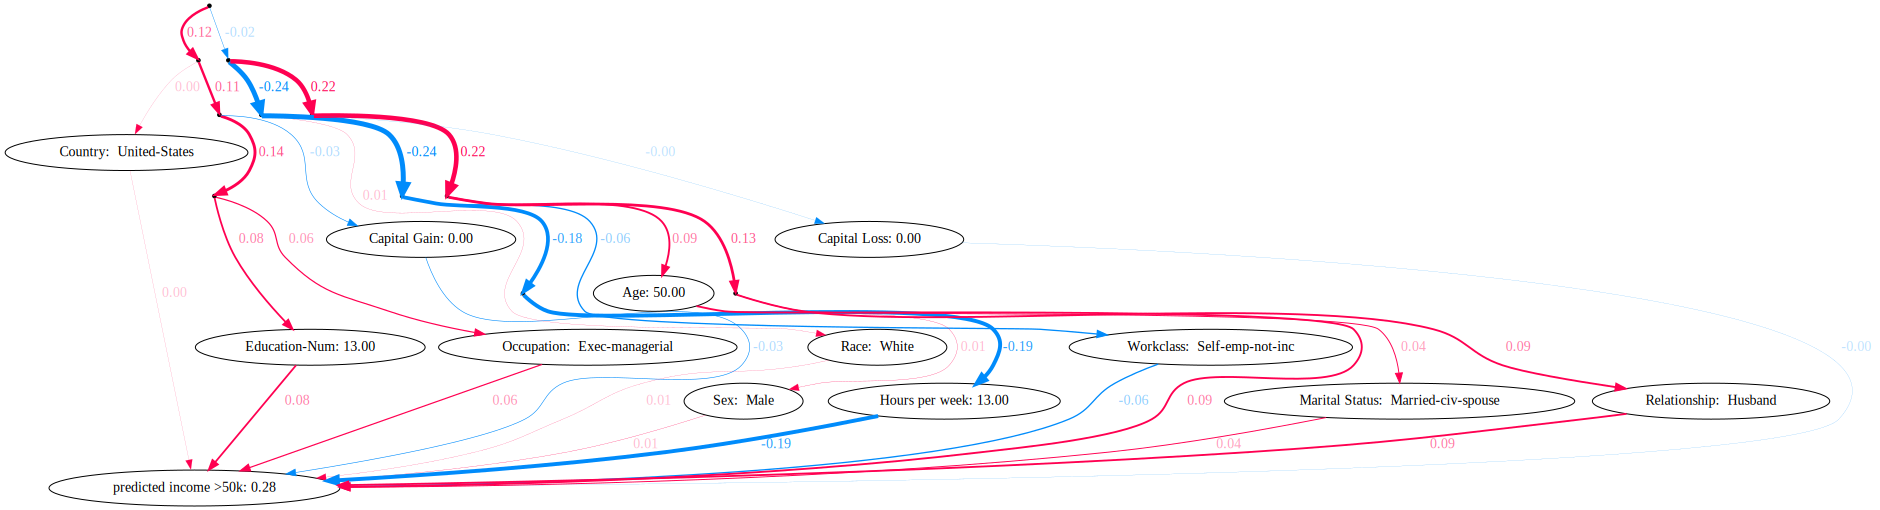

In [18]:
cf_h.draw(1, max_display=None)

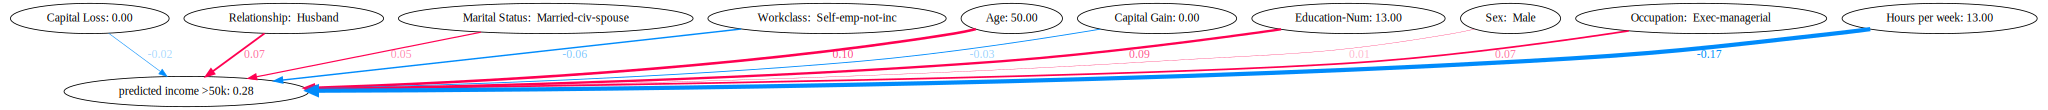

In [19]:
cf.draw(1, max_display=10)

# Comparison of exact methods

In [49]:
#bg = shap.utils.sample(X, 300)
bg = np.vstack([X.iloc[0], X.iloc[0]])
masker = shap.maskers.TabularPartitions(bg)
masker.partition_tree = cluster_matrix
explainer = shap.Explainer(lambda x: model.predict(xgboost.DMatrix(x), validate_features=False), masker)
shap_values = explainer(X[:2])

AttributeError: module 'shap.maskers' has no attribute 'TabularPartitions'

In [33]:
explainer

cannot set multiprocessing to spawn,             use ParallelCreditFlow with caution


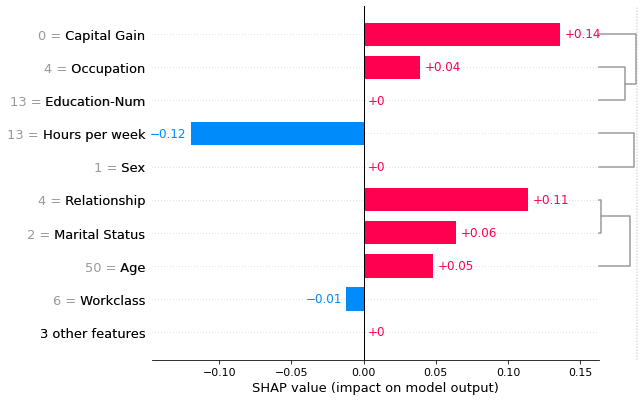

In [38]:
i = 1
shap.plots.bar(shap_values[i], clustering=cluster_matrix, cluster_threshold=0.9)
# shap.plots.waterfall(shap_values[i], max_display=20)

In [50]:
# graph = build_graph(model, X, translator(X.columns, X, X_display))
E = GraphExplainer(graph, X.iloc[:1])
E.prepare_graph(X[:nsamples])
cf_h = CreditFlow(hcluster_graph(E.graph, list(X.columns), cluster_matrix), nruns=-1)
cf_h.run(method='divide_and_conquer')

ValueError: 'Hours per week noise' is not in list

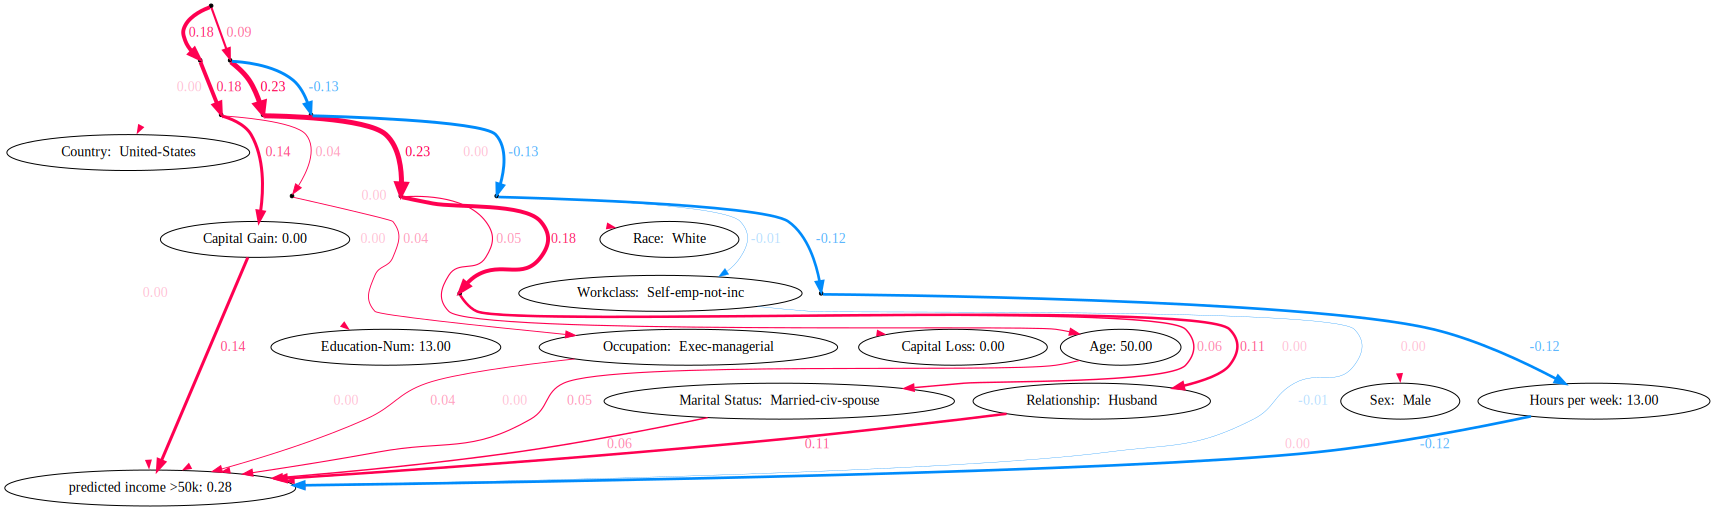

In [43]:
cf_h.draw(1)

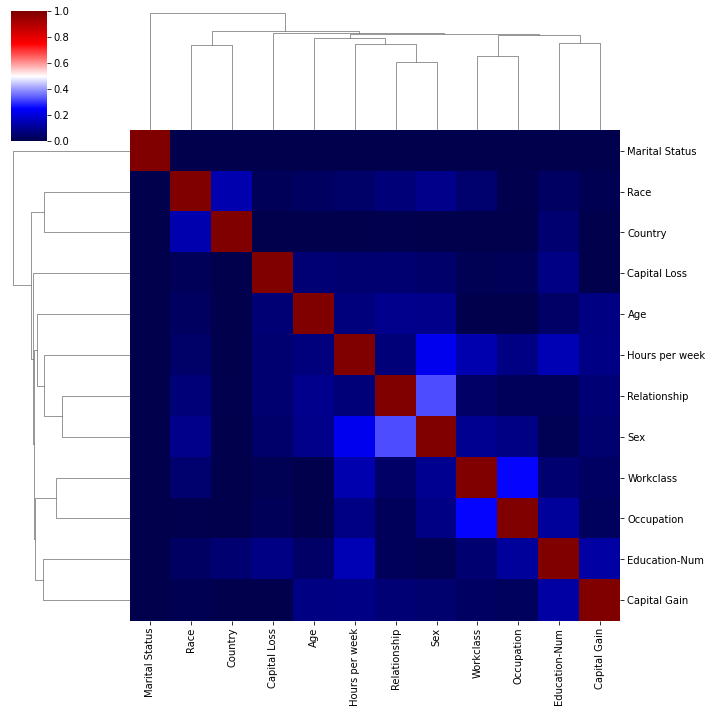

In [64]:
sns.clustermap(X.corr(), cmap='seismic', vmax=1, vmin=0)

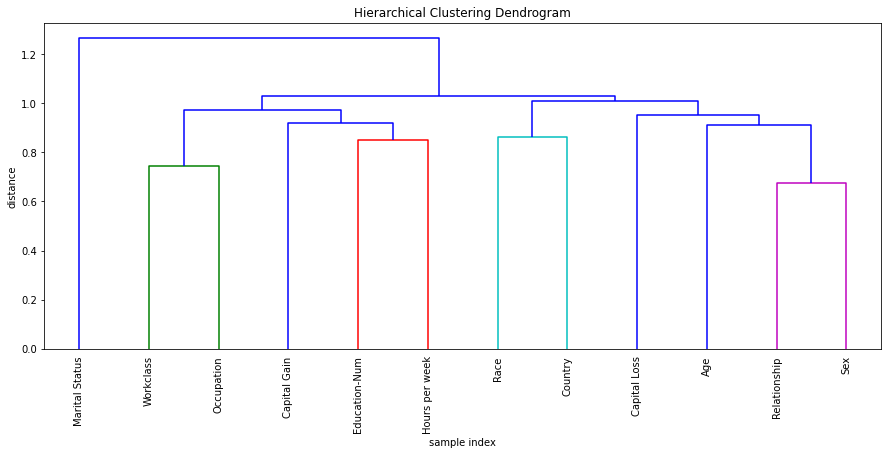

In [20]:
D = sp.spatial.distance.pdist(X.fillna(X.mean()).T, metric="correlation")
cluster_matrix = sp.cluster.hierarchy.complete(D)

# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

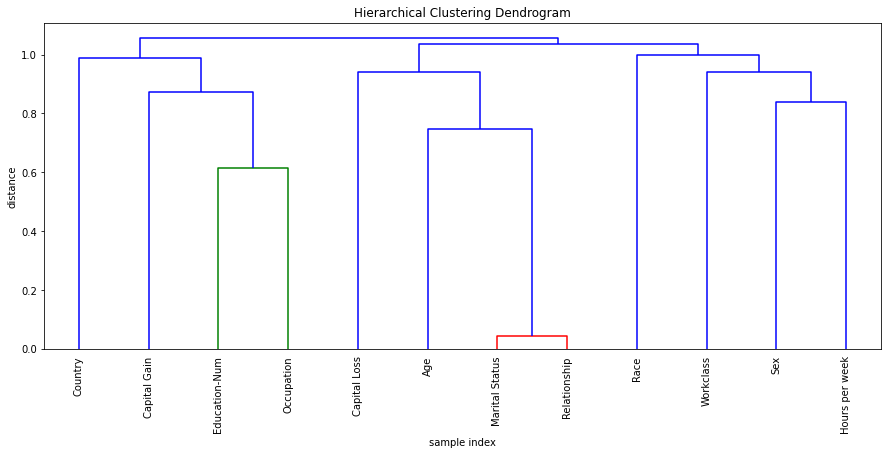

In [10]:
cluster_matrix = shap.utils.hclust(X, y)

# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

# Incorporate a causal understanding 

Following the ASV paper, we group features that are determined at birth from the rest of the features

Therefore, we have the following causal graph:

In [6]:
A = ['Age', 'Sex', 'Country', 'Race']
D = list(set(X.columns) - set(A))
A, D

(['Age', 'Sex', 'Country', 'Race'],
 ['Education-Num',
  'Marital Status',
  'Workclass',
  'Relationship',
  'Capital Loss',
  'Occupation',
  'Hours per week',
  'Capital Gain'])

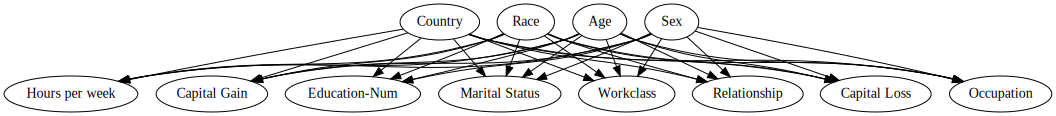

In [7]:
dot = Digraph()
idx = 0
idx_A = []
idx_D = []
for name in A:
    dot.node(f'{idx}', name)
    idx_A.append(idx)
    idx += 1

for name in D:
    dot.node(f'{idx}', name)
    idx_D.append(idx)
    idx += 1

for a, d in product(idx_A, idx_D):
    dot.edge(str(a), str(d))
dot

While causal ordering requires that features should occur at specific order, the noise terms of the nodes have no reason to follow that. Theirfore a complete causal graph looks like this.

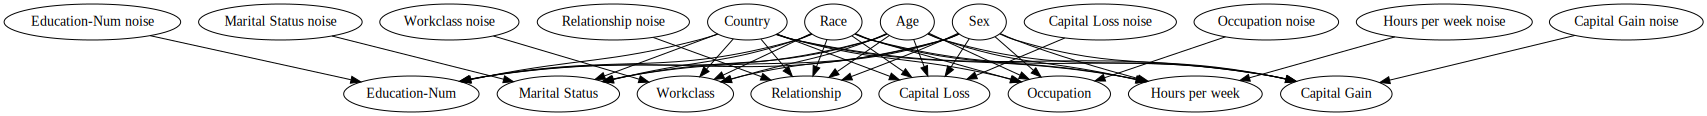

In [8]:
dot = Digraph()
idx = 0
idx_A = []
idx_D = []
idx_D_noise = []
for name in A:
    dot.node(f'{idx}', name)
    idx_A.append(idx)
    idx += 1

for name in D:
    dot.node(f'{idx}', name)
    idx_D.append(idx)
    idx += 1

for name in D:
    dot.node(f'{idx}', name + ' noise')
    idx_D_noise.append(idx)
    idx += 1

for a, d in product(idx_A, idx_D):
    dot.edge(str(a), str(d))
    
for d_n, d in zip(idx_D_noise, idx_D):
    dot.edge(str(d_n), str(d))
    
dot

In [9]:
def build_graph(model, X, display_translator={}):
    '''
    build and return a graph (list of nodes), to be runnable in main
    model: xgboost model
    X: background distribution (n, d) dataframe object
    x: target samples to be explained (n2, d)
    names: the feature names of the d dimensional features
    display_translator: translate features values to readable format, see flow.py:translator
    '''
    categorical_features = ['Workclass', 'Marital Status', 'Occupation',
                            'Relationship', 'Race', 'Sex', 'Country']
    
    def create_f(parents, m):
        def f_(*args):
            bs = len(args[0])
            o = m.predict(xgboost.DMatrix(pd.DataFrame.from_dict(dict((n.name, args[i]) for i, n in enumerate(parents)))))
            if len(o) != bs: # discrete case
                o = o.reshape(bs, -1)
            return o
        return f_

    # build the graph
    names = list(X.columns)
    
    # note the ancestor and other nodes and sort according to names order
    A = ['Age', 'Sex', 'Country', 'Race']
    D = list(set(names) - set(A))
    A = sorted(A, key=lambda x: names.index(x))
    D = sorted(D, key=lambda x: names.index(x))
    
    nodes = []
    nodes_A = []
    nodes_D = []
    for name in A:
        node = Node(name)
        nodes.append(node)
        nodes_A.append(node)

    pbar = tqdm.tqdm(list(enumerate(D)))
    for i, name in pbar:
        pbar.set_description(f'learning dependency for {name}')
        parents = nodes_A
        
        # learn a new model here
        X_train, X_test, y_train, y_test = train_test_split(X[[p.name for p in parents]], np.array(X[name]), test_size=0.2, random_state=7)
        xgb_train = xgboost.DMatrix(X_train, label=y_train)
        xgb_test = xgboost.DMatrix(X_test, label=y_test)
        
        if name in categorical_features:
            
            num_class = len(np.unique(X[name]))
            params = {
                "eta": 0.002,
                "max_depth": 3,
                'objective': 'multi:softprob',
                'eval_metric': 'mlogloss',
                'num_class': num_class,
                "subsample": 0.5
            }
        else:
            params = {
                "eta": 0.002,
                "max_depth": 3,
                'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                "subsample": 0.5
            }
        m = xgboost.train(params, xgb_train, 500, evals = [(xgb_test, "test")], verbose_eval=100) #False)
            
        # use the new model:
        node = Node(name, 
                    create_f(parents, m), 
                    parents)
        nodes_D.append(node)
        nodes.append(node)
    
    parents = sorted(nodes_A + nodes_D, key=lambda x: names.index(x.name))
    nodes.append(Node('predicted income >50k', 
                      create_f(parents, model), 
                      parents, is_target_node=True))
    
    graph = Graph(nodes, display_translator=display_translator)
    return graph
    
nsamples = 1000
graph = build_graph(model, X, translator(X.columns, X, X_display))

learning dependency for Workclass:   0%|          | 0/8 [00:00<?, ?it/s]

[0]	test-mlogloss:2.19314
[100]	test-mlogloss:1.88313
[200]	test-mlogloss:1.68807
[300]	test-mlogloss:1.55192
[400]	test-mlogloss:1.45190
[499]	test-mlogloss:1.37679


learning dependency for Education-Num:  12%|█▎        | 1/8 [00:13<01:35, 13.59s/it]

[0]	test-rmse:9.87932
[100]	test-rmse:8.20241
[200]	test-rmse:6.85282
[300]	test-rmse:5.77531
[400]	test-rmse:4.92298
[499]	test-rmse:4.26283


learning dependency for Marital Status:  25%|██▌       | 2/8 [00:15<01:00, 10.04s/it]

[0]	test-mlogloss:1.94271
[100]	test-mlogloss:1.68994
[200]	test-mlogloss:1.51876
[300]	test-mlogloss:1.39377
[400]	test-mlogloss:1.29888
[499]	test-mlogloss:1.22575


learning dependency for Occupation:  38%|███▊      | 3/8 [00:25<00:50, 10.04s/it]    

[0]	test-mlogloss:2.70708
[100]	test-mlogloss:2.62392
[200]	test-mlogloss:2.56027
[300]	test-mlogloss:2.51008
[400]	test-mlogloss:2.46980
[499]	test-mlogloss:2.43720


learning dependency for Relationship:  50%|█████     | 4/8 [00:45<00:52, 13.18s/it]

[0]	test-mlogloss:1.78961
[100]	test-mlogloss:1.61357
[200]	test-mlogloss:1.48895
[300]	test-mlogloss:1.39597
[400]	test-mlogloss:1.32445
[499]	test-mlogloss:1.26879


learning dependency for Capital Gain:  62%|██████▎   | 5/8 [00:55<00:35, 11.99s/it]

[0]	test-rmse:7415.93311
[100]	test-rmse:7376.77978
[200]	test-rmse:7350.35889
[300]	test-rmse:7332.08057
[400]	test-rmse:7319.50147
[499]	test-rmse:7310.94922


learning dependency for Capital Loss:  75%|███████▌  | 6/8 [00:56<00:17,  8.86s/it]

[0]	test-rmse:410.60251
[100]	test-rmse:407.19025
[200]	test-rmse:404.91232
[300]	test-rmse:403.38498
[400]	test-rmse:402.36392
[499]	test-rmse:401.68555


learning dependency for Hours per week:  88%|████████▊ | 7/8 [00:58<00:06,  6.65s/it]

[0]	test-rmse:41.79467
[100]	test-rmse:34.81621
[200]	test-rmse:29.21365
[300]	test-rmse:24.75079
[400]	test-rmse:21.23435
[499]	test-rmse:18.52407


learning dependency for Hours per week: 100%|██████████| 8/8 [00:59<00:00,  7.45s/it]


cannot set multiprocessing to spawn,             use ParallelCreditFlow with caution


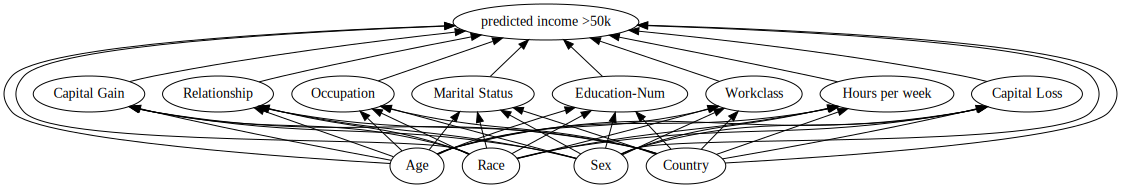

In [317]:
graph.draw()

In [53]:
save_graph(graph.to_graphviz(), 'income_causal_graph.png')

In [71]:
cf_o = GraphExplainer(graph, X, nruns=100).shap_values(X[:nsamples]) 

bruteforce sampling: 100%|██████████| 100/100 [03:58<00:00,  2.38s/it]


cannot set multiprocessing to spawn,             use ParallelCreditFlow with caution


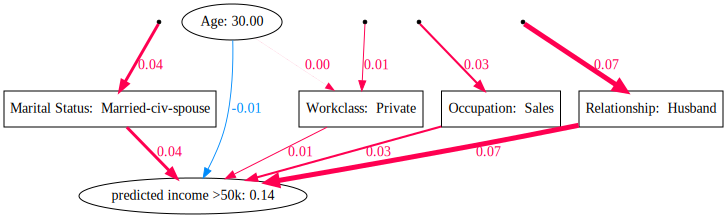

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f76b8cf2b10>>

In [65]:
sample_ind = 60
cf_o.fold_noise = True
cf_o.draw(idx=sample_ind, max_display=10)

In [72]:
cf_f = GraphExplainer(flatten_graph(graph), X, nruns=100).shap_values(X[:nsamples])

bruteforce sampling: 100%|██████████| 100/100 [00:35<00:00,  2.83it/s]


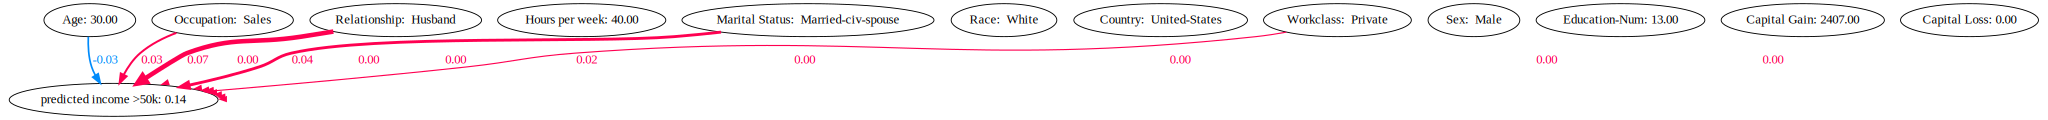

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f7668050570>>

In [73]:
cf_f.draw(60)

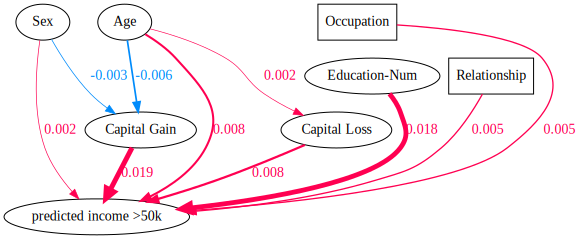

In [460]:
def global_view_binary_prob(edge_credit, y):
    s = (np.array(y).astype(int) - 0.5) * 2 # get the sign
    ec = defaultdict(lambda: defaultdict(int))
    for node1, d in edge_credit.items():
        for node2, val in d.items():
            ec[node1][node2] = np.array([(val * s).mean(0)])  # by linearity
    return ec

ec = global_view_binary_prob(cf_o.edge_credit, y[:nsamples])
cf_o.fold_noise = True
g = cf_o.draw(0, max_display=10, edge_credit=ec, format_str="{:.3f}", show_fg_val=False)
save_graph(g, f'figures/income_flow_-1.png')

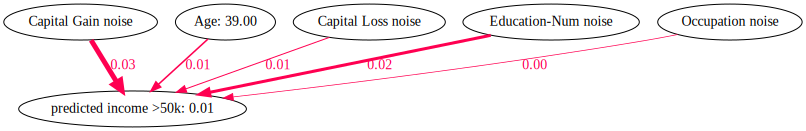

In [420]:
cf_o.fold_noise = False
ec = global_view_binary_prob(cf_o.get_asv_edge_credit(aggregate=False), y[:nsamples])
g = cf_o.draw_asv(0, max_display=5, flow_credit=ec)
# save_graph(g, f'figures/income_asv_{sample_ind}.png')

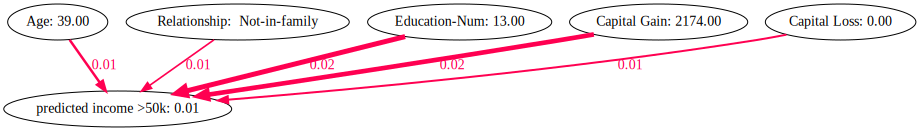

In [408]:
ec = global_view_binary_prob(cf_f.edge_credit, y[:nsamples])

cf_f.fold_noise = True
g = cf_f.draw(0, max_display=5, edge_credit=ec)
# save_graph(g, f'figures/income_shap_{sample_ind}.png')

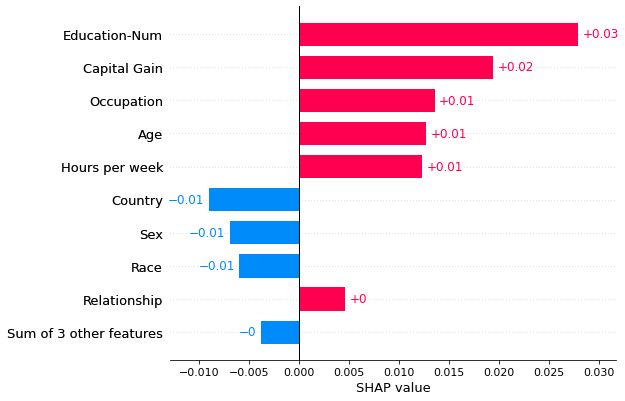

In [386]:
def global_view_binary_prob_manifold(values, y):
    s = (np.array(y).astype(int) - 0.5) * 2 # get the sign
    return ((s * values.T).T).mean(0).reshape(1, -1)

values = global_view_binary_prob_manifold(cf_on_manifold.values, y[:100])#y[:nsamples])

cf_on_manifold.draw(max_display=10, values=values)
# save_graph(g, f'figures/income_shap_{sample_ind}.png')

In [422]:
latex_dict = {}

# asv
def prepare_bar_asv_global(target_node, edge_credit):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node].mean() for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    b.data = None #np.arange(len(b.input_names))
    b.transform_history = []
    return b

target_node = [i for i in cf_o.graph if i.is_target_node][0]
edge_credit = global_view_binary_prob(cf_o.get_asv_edge_credit(aggregate=False), y[:nsamples])
b = prepare_bar_asv_global(target_node, edge_credit)
latex_dict['asv'] = {k:v for k,v in zip(map(lambda n: n[:-6] if n[-5:] == 'noise' else n,
                                            b.input_names), 
                                        b.values)}

# shap
def prepare_bar_shap_global(target_node, edge_credit):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node].mean() for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    b.data = None # np.arange(len(b.input_names))
    b.transform_history = []
    return b

target_node = [i for i in cf_f.graph if i.is_target_node][0]
edge_credit = global_view_binary_prob(cf_f.edge_credit, y[:nsamples])
b = prepare_bar_shap_global(target_node, edge_credit)
latex_dict['ind'] = {k:v for k,v in zip(b.input_names, b.values)}

# on manifold
def prepare_on_manifold_global(cf, y):
    s = (np.array(y).astype(int) - 0.5) * 2 # get the sign
    values = (s * cf.values.T).T

    class D(): pass
    b.input_names = cf.input_names
    b.values = values.mean(0)
    return b

b = prepare_on_manifold_global(cf_on_manifold, y[:100])
latex_dict['manifold'] = {k:v for k,v in zip(b.input_names, b.values)}

# resulting data frame
df = pd.DataFrame.from_dict(latex_dict).loc[:, ['ind', 'manifold', 'asv']]
# print(df.round(2).to_latex())

############# add colors
colors = np.array(df)

# normalize each column by the largest absolute value
for i in range(colors.shape[1]):
    colors[:, i] /= np.abs(colors[:, i]).max()
    colors[:, i] *= 100
colors = colors.astype(np.int)

# sort index by its abs score across columns
feature_order = np.abs(colors).sum(1).argsort()[::-1]

### latex output
table = "\\begin{tabular}{lrrr}\n\\toprule\n"
table += r"{} & Independent & On-manifold & ASV\\"
table += "\n\\midrule\n"
for i in feature_order:
    row = []
    feature_name = df.iloc[i].name
    row.append(feature_name)
    for j in range(colors.shape[1]):
        v = df.iloc[i, j].round(2)
        c = "blue" if colors[i, j] < 0 else "red"
        c = f"\\cellcolor{{{c}!{np.abs(colors[i,j])}}}"
        row.append(f"{c} {v}")
    table += r" & ".join(row)
    table += "\\\\\n"
table += "\\bottomrule\n\\end{tabular}"
print(table)

\begin{tabular}{lrrr}
\toprule
{} & Independent & On-manifold & ASV\\
\midrule
Capital Gain & \cellcolor{red!92} 0.02 & \cellcolor{red!69} 0.02 & \cellcolor{red!100} 0.03\\
Education-Num & \cellcolor{red!100} 0.02 & \cellcolor{red!100} 0.03 & \cellcolor{red!60} 0.02\\
Age & \cellcolor{red!49} 0.01 & \cellcolor{red!45} 0.01 & \cellcolor{red!30} 0.01\\
Occupation & \cellcolor{red!21} 0.0 & \cellcolor{red!48} 0.01 & \cellcolor{red!13} 0.0\\
Capital Loss & \cellcolor{red!39} 0.01 & \cellcolor{blue!14} -0.0 & \cellcolor{red!19} 0.01\\
Relationship & \cellcolor{red!32} 0.01 & \cellcolor{red!16} 0.0 & \cellcolor{red!7} 0.0\\
Hours per week & \cellcolor{red!2} 0.0 & \cellcolor{red!44} 0.01 & \cellcolor{blue!3} -0.0\\
Sex & \cellcolor{red!16} 0.0 & \cellcolor{blue!24} -0.01 & \cellcolor{red!8} 0.0\\
Country & \cellcolor{red!2} 0.0 & \cellcolor{blue!32} -0.01 & \cellcolor{red!1} 0.0\\
Marital Status & \cellcolor{blue!10} -0.0 & \cellcolor{red!8} 0.0 & \cellcolor{blue!8} -0.0\\
Race & \cellcolor{

In [236]:
X_display.iloc[0]

Age                           39
Workclass              State-gov
Education-Num                 13
Marital Status     Never-married
Occupation          Adm-clerical
Relationship       Not-in-family
Race                       White
Sex                         Male
Capital Gain                2174
Capital Loss                   0
Hours per week                40
Country            United-States
Name: 0, dtype: object

# Investigate the samples

In [456]:
sample_ind = 33
print('baseline', model.predict(xgboost.DMatrix(X.iloc[0:1])))
print('target:', model.predict(xgboost.DMatrix(X.iloc[sample_ind:sample_ind+1])))
X_display.iloc[[0, sample_ind]]

baseline [0.00712833]
target: [0.07471998]


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
33,30.0,Federal-gov,10.0,Married-civ-spouse,Adm-clerical,Own-child,White,Male,0.0,0.0,40.0,United-States


In [457]:
print(X_display.iloc[[0, sample_ind]].rename(index={0: 'Background sample', sample_ind: 'Foreground sample'}).T.to_latex()) #.loc[:, ['Education-Num', 'Relationship', 'Capital Gain', 'Occupation']].to_latex())

\begin{tabular}{lll}
\toprule
{} & Background sample &    Foreground sample \\
\midrule
Age            &                39 &                   30 \\
Workclass      &         State-gov &          Federal-gov \\
Education-Num  &                13 &                   10 \\
Marital Status &     Never-married &   Married-civ-spouse \\
Occupation     &      Adm-clerical &         Adm-clerical \\
Relationship   &     Not-in-family &            Own-child \\
Race           &             White &                White \\
Sex            &              Male &                 Male \\
Capital Gain   &              2174 &                    0 \\
Capital Loss   &                 0 &                    0 \\
Hours per week &                40 &                   40 \\
Country        &     United-States &        United-States \\
\bottomrule
\end{tabular}



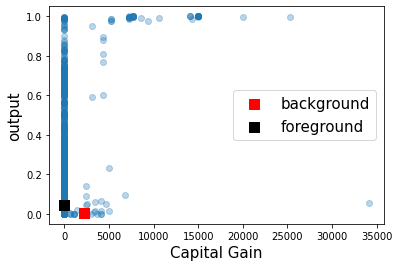

In [327]:
nsamples = 1000
o = f(np.array(X)[:nsamples])

xlabel = 'Capital Gain'
ylabel = 'output'
plt.scatter(X[xlabel][:nsamples], o, alpha=0.3)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.scatter(X[xlabel][[0]], o[[0]], c=['red'], s=100, marker='s', label='background')
plt.scatter(X[xlabel][[sample_ind]], o[[sample_ind]], c=['black'], s=100, marker='s', label='foreground')
plt.legend(fontsize=15)

# Comparison of views

Flow


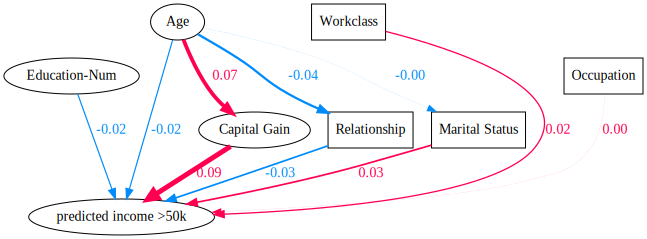

In [458]:
print('Flow')
sample_ind = 33 # 11 22 33 99 100 : sex has oppossing sign 22: race important overall but not directly
cf_o.fold_noise = True
g = cf_o.draw(idx=sample_ind, max_display=10, show_fg_val=False)
save_graph(g, f'figures/income_flow_{sample_ind}.png')

ASV


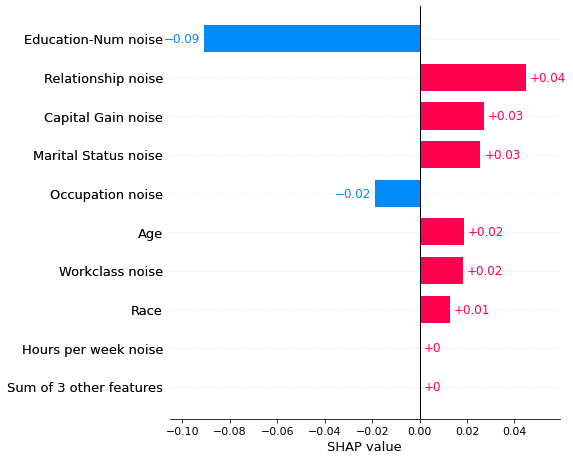

In [262]:
# asv
print('ASV')
def prepare_bar_asv(target_node, edge_credit, sample_ind):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    b.data = None #np.arange(len(b.input_names))
    b.transform_history = []
    return b


target_node = [i for i in cf_o.graph if i.is_target_node][0]
edge_credit = cf_o.get_asv_edge_credit(sample_ind)

b = prepare_bar_asv(target_node, edge_credit, sample_ind)
shap.plots.bar(b, max_display=10, show=False)
plt.tight_layout()
plt.savefig(f'figures/income_asv_{sample_ind}.png')
plt.show()

# cf_o.fold_noise = False
# g = cf_o.draw_asv(sample_ind, max_display=5)
# save_graph(g, f'figures/income_asv_{sample_ind}.png')

Independent


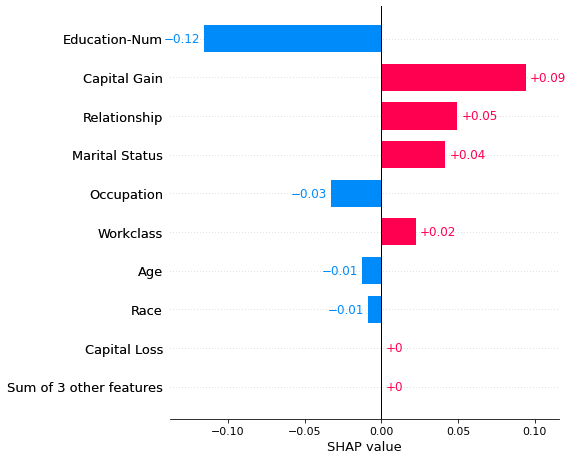

In [263]:
# shap
print('Independent')
def prepare_bar_shap(target_node, edge_credit, sample_ind):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node][sample_ind] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    b.data = None # np.arange(len(b.input_names))
    b.transform_history = []
    return b


target_node = [i for i in cf_f.graph if i.is_target_node][0]
edge_credit = cf_f.edge_credit

b = prepare_bar_shap(target_node, edge_credit, sample_ind)
shap.plots.bar(b, max_display=10, show=False)
plt.tight_layout()
plt.savefig(f'figures/income_shap_{sample_ind}.png')
plt.show()

# g = cf_f.draw(sample_ind, max_display=5)
# save_graph(g, f'figures/income_shap_{sample_ind}.png')

On manifold


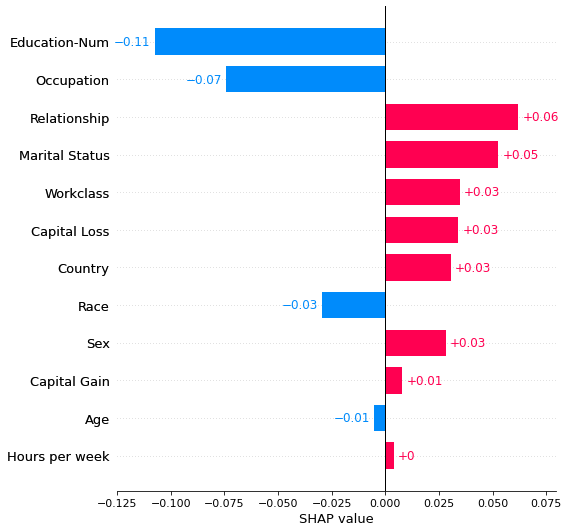

In [264]:
print('On manifold')
cf_on_manifold.draw(sample_ind, show=False)
plt.tight_layout()
plt.savefig(f'figures/income_manifold_{sample_ind}.png')
plt.show()

In [37]:
X_display.iloc[sample_ind]

Age                                35
Workclass                 Federal-gov
Education-Num                       5
Marital Status     Married-civ-spouse
Occupation            Farming-fishing
Relationship                  Husband
Race                            Black
Sex                              Male
Capital Gain                        0
Capital Loss                        0
Hours per week                     40
Country                 United-States
Name: 22, dtype: object

# Output to latex

In [453]:
latex_dict = {}

# asv
def prepare_bar_asv(target_node, edge_credit, sample_ind):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    b.data = None #np.arange(len(b.input_names))
    b.transform_history = []
    return b

target_node = [i for i in cf_o.graph if i.is_target_node][0]
edge_credit = cf_o.get_asv_edge_credit(sample_ind)
b = prepare_bar_asv(target_node, edge_credit, sample_ind)
latex_dict['asv'] = {k:v for k,v in zip(map(lambda n: n[:-6] if n[-5:] == 'noise' else n,
                                            b.input_names), 
                                        b.values)}

# shap
def prepare_bar_shap(target_node, edge_credit, sample_ind):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node][sample_ind] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    b.data = None # np.arange(len(b.input_names))
    b.transform_history = []
    return b

target_node = [i for i in cf_f.graph if i.is_target_node][0]
edge_credit = cf_f.edge_credit
b = prepare_bar_shap(target_node, edge_credit, sample_ind)
latex_dict['ind'] = {k:v for k,v in zip(b.input_names, b.values)}

# on manifold
def prepare_on_manifold(cf, sample_ind):
    class D(): pass
    b.input_names = cf.input_names
    b.values = cf.values[sample_ind]
    return b

b = prepare_on_manifold(cf_on_manifold, sample_ind)
latex_dict['manifold'] = {k:v for k,v in zip(b.input_names, b.values)}

# resulting data frame
df = pd.DataFrame.from_dict(latex_dict).loc[:, ['ind', 'manifold', 'asv']]
print(df.round(2).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &   ind &  manifold &   asv \\
\midrule
Sex            &  0.00 &      0.03 &  0.00 \\
Capital Gain   &  0.06 &      0.02 &  0.02 \\
Age            & -0.02 &     -0.03 &  0.01 \\
Marital Status &  0.03 &      0.08 &  0.03 \\
Capital Loss   &  0.00 &      0.03 &  0.00 \\
Country        &  0.00 &      0.03 &  0.00 \\
Workclass      &  0.03 &      0.03 &  0.02 \\
Education-Num  & -0.02 &      0.01 & -0.02 \\
Race           &  0.00 &      0.02 &  0.00 \\
Occupation     &  0.00 &     -0.03 &  0.00 \\
Hours per week &  0.00 &     -0.00 &  0.00 \\
Relationship   & -0.01 &     -0.11 &  0.01 \\
\bottomrule
\end{tabular}



In [454]:
colors = np.array(df)

# normalize each column by the largest absolute value
for i in range(colors.shape[1]):
    colors[:, i] /= np.abs(colors[:, i]).max()
    colors[:, i] *= 100
colors = colors.astype(np.int)

# sort index by its abs score across columns
feature_order = np.abs(colors).sum(1).argsort()[::-1]

In [455]:
table = "\\begin{tabular}{lrrr}\n\\toprule\n"
table += r"{} & Independent & On-manifold & ASV\\"
table += "\n\\midrule\n"
for i in feature_order:
    row = []
    feature_name = df.iloc[i].name
    row.append(feature_name)
    for j in range(colors.shape[1]):
        v = df.iloc[i, j].round(2)
        c = "blue" if colors[i, j] < 0 else "red"
        c = f"\\cellcolor{{{c}!{np.abs(colors[i,j])}}}"
        row.append(f"{c} {v}")
    table += r" & ".join(row)
    table += "\\\\\n"
table += "\\bottomrule\n\\end{tabular}"
print(table)

\begin{tabular}{lrrr}
\toprule
{} & Independent & On-manifold & ASV\\
\midrule
Marital Status & \cellcolor{red!58} 0.03 & \cellcolor{red!69} 0.08 & \cellcolor{red!100} 0.03\\
Capital Gain & \cellcolor{red!100} 0.06 & \cellcolor{red!15} 0.02 & \cellcolor{red!71} 0.02\\
Workclass & \cellcolor{red!50} 0.03 & \cellcolor{red!26} 0.03 & \cellcolor{red!74} 0.02\\
Relationship & \cellcolor{blue!13} -0.01 & \cellcolor{blue!100} -0.11 & \cellcolor{red!32} 0.01\\
Education-Num & \cellcolor{blue!40} -0.02 & \cellcolor{red!11} 0.01 & \cellcolor{blue!68} -0.02\\
Age & \cellcolor{blue!38} -0.02 & \cellcolor{blue!30} -0.03 & \cellcolor{red!22} 0.01\\
Country & \cellcolor{red!0} 0.0 & \cellcolor{red!29} 0.03 & \cellcolor{red!0} 0.0\\
Capital Loss & \cellcolor{red!0} 0.0 & \cellcolor{red!25} 0.03 & \cellcolor{red!0} 0.0\\
Occupation & \cellcolor{red!0} 0.0 & \cellcolor{blue!23} -0.03 & \cellcolor{red!0} 0.0\\
Sex & \cellcolor{red!0} 0.0 & \cellcolor{red!23} 0.03 & \cellcolor{red!0} 0.0\\
Race & \cellcol

\begin{tabular}{lllll}
\hline
\multicolumn{1}{l}{Attribution to $X_1$ (or edge $a$)} & \multicolumn{1}{l}{$F_1$} & \multicolumn{1}{l}{$F_2$} & \multicolumn{1}{l}{$F_3$} & \multicolumn{1}{l}{$F_4$} \\ \hline
Independent & 1 & 0 & 0 & 0\\
On-manifold & 1 & 1/2 & 1/3 & 1/4 \\
ASV or Shapley Flow & 1 & 1 & 1 & 1
\end{tabular}

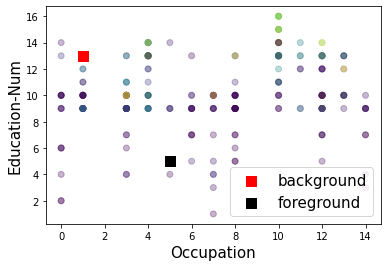

In [312]:
nsamples = 300
o = f(np.array(X)[:nsamples])
def normalize(o): # normalize to 0-1
    return (o - o.min()) / (o.max() - o.min())

xlabel = 'Occupation'
ylabel = 'Education-Num'

# xlabel = 'Age'
# ylabel = 'Serum Magnesium'

plt.scatter(X[xlabel][:nsamples], X[ylabel][:nsamples], c=normalize(o), alpha=0.3)
# sns.regplot(X[xlabel][:nsamples], X[ylabel][:nsamples], x_bins=1, order=1, ci=None)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)

plt.scatter(X[xlabel][[0]], X[ylabel][[0]], c=['red'], s=100, marker='s', label='background')
plt.scatter(X[xlabel][[sample_ind]], X[ylabel][[sample_ind]], c=['black'], s=100, marker='s', label='foreground')
plt.legend(fontsize=15)

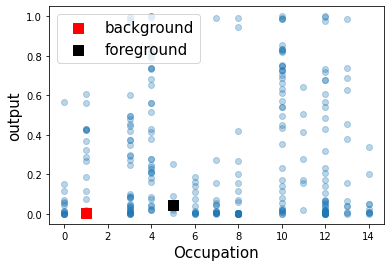

In [314]:
nsamples = 300
o = f(np.array(X)[:nsamples])

xlabel = 'Occupation'
ylabel = 'output'
plt.scatter(X[xlabel][:nsamples], o, alpha=0.3)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.scatter(X[xlabel][[0]], o[[0]], c=['red'], s=100, marker='s', label='background')
plt.scatter(X[xlabel][[sample_ind]], o[[sample_ind]], c=['black'], s=100, marker='s', label='foreground')
plt.legend(fontsize=15)

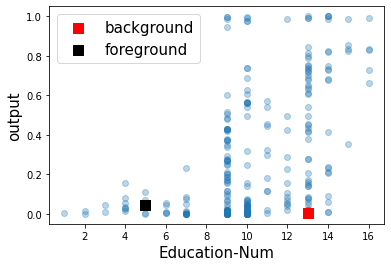

In [315]:
nsamples = 300
o = f(np.array(X)[:nsamples])

xlabel = 'Education-Num'
ylabel = 'output'
plt.scatter(X[xlabel][:nsamples], o, alpha=0.3)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.scatter(X[xlabel][[0]], o[[0]], c=['red'], s=100, marker='s', label='background')
plt.scatter(X[xlabel][[sample_ind]], o[[sample_ind]], c=['black'], s=100, marker='s', label='foreground')
plt.legend(fontsize=15)

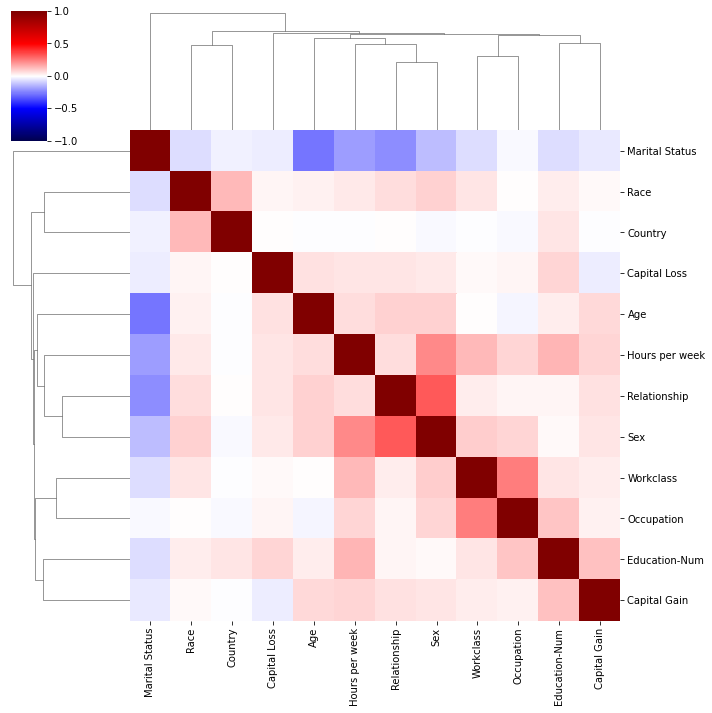

In [316]:
sns.clustermap(X.corr(), cmap='seismic', vmax=1, vmin=-1)

# on-manifold perturbation

In [243]:
nsamples = 100
feature_names = X.columns
f = lambda x: model.predict(xgboost.DMatrix(pd.DataFrame(x, columns=feature_names)))
explainer = OnManifoldExplainer(f, X.iloc[:100], nruns=100, sigma_sq=1e-1) 
cf_on_manifold = explainer.shap_values(X[:nsamples])

100%|██████████| 100/100 [09:32<00:00,  5.73s/it]


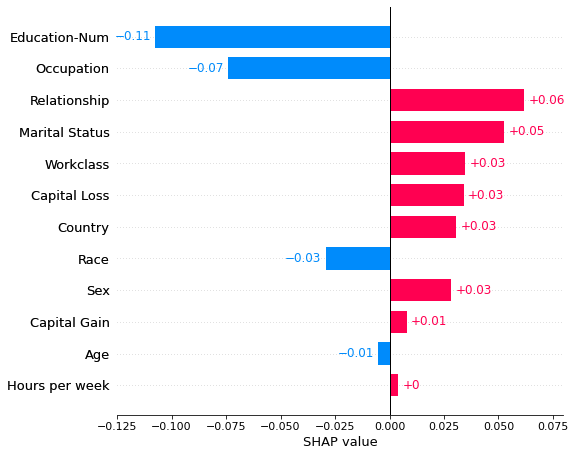

In [244]:
cf_on_manifold.draw(sample_ind)

(-0.1, 1.1)

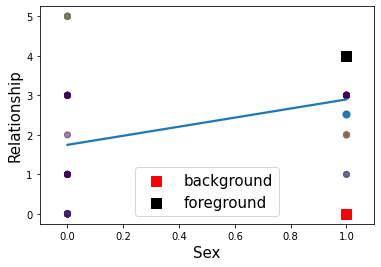

In [245]:
nsamples = 300
o = f(np.array(X)[:nsamples])
def normalize(o): # normalize to 0-1
    return (o - o.min()) / (o.max() - o.min())

xlabel = 'Sex'
ylabel = 'Relationship'

# xlabel = 'Age'
# ylabel = 'Serum Magnesium'

plt.scatter(X[xlabel][:nsamples], X[ylabel][:nsamples], c=normalize(o), alpha=0.3)
sns.regplot(X[xlabel][:nsamples], X[ylabel][:nsamples], x_bins=1, order=1, ci=None)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)

plt.scatter(X[xlabel][[0]], X[ylabel][[0]], c=['red'], s=100, marker='s', label='background')
plt.scatter(X[xlabel][[sample_ind]], X[ylabel][[sample_ind]], c=['black'], s=100, marker='s', label='foreground')
plt.legend(fontsize=15)
plt.xlim(-0.1, 1.1)

# use barcharts to visualize

In [214]:
# shap
def prepare_bar_shap(target_node, edge_credit, sample_ind):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node][sample_ind] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    b.data = None # np.arange(len(b.input_names))
    b.transform_history = []
    return b


target_node = [i for i in cf_f.graph if i.is_target_node][0]
edge_credit = cf_f.edge_credit

b = prepare_bar_shap(target_node, edge_credit, sample_ind)

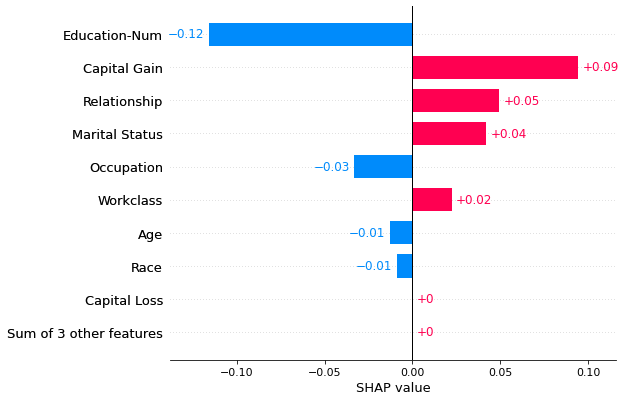

In [215]:
# shap
shap.plots.bar(b)

In [216]:
# asv
def prepare_bar_asv(target_node, edge_credit, sample_ind):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    b.data = None #np.arange(len(b.input_names))
    b.transform_history = []
    return b


target_node = [i for i in cf_o.graph if i.is_target_node][0]
edge_credit = cf_o.get_asv_edge_credit(sample_ind)

b = prepare_bar_asv(target_node, edge_credit, sample_ind)

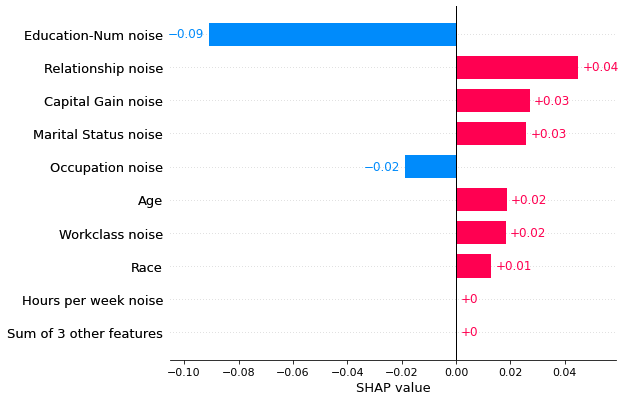

In [217]:
# asv
shap.plots.bar(b)

# save and load existing models

In [160]:
import dill
# dill.dump(cf_f, open('adult_cf.pkl', 'wb'))
# dill.dump(cf_o, open('adult_cf_c.pkl', 'wb'))

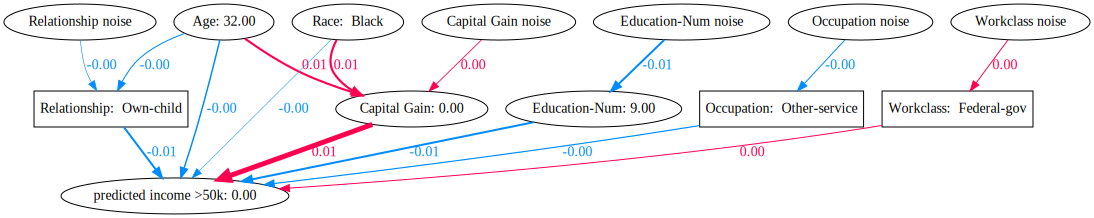

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f76ad482cf0>>

In [155]:
dill.load(open('adult_cf_c.pkl', 'rb')).draw(99, max_display=15)

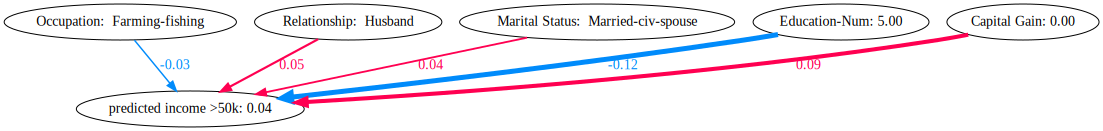

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f76ad639c00>>

In [161]:
cf_ = dill.load(open('adult_cf.pkl', 'rb'))
cf_.draw(sample_ind, max_display=5)